# 1. Housekeeping

In [8]:
import ciao_contrib.runtool
from ciao_contrib.runtool import *
import pandas as pd
import numpy as np
from numpy import load
import astropy 
from astropy.table import Table
from astropy.io import fits
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pickle
import statistics
from IPython.display import clear_output

# List Folders Function
def list_folders(path):
    return [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    
# Specify path
path = '/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Chandra-Data/'
folders = list_folders(path)
folder_list = []
for folder in folders:
    folder_list.append(folder)

# Select Set
set_widget = widgets.Dropdown(options=folder_list[:],value=folder_list[1],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', index=1, options=('Set-2', 'Set-Y', 'Set-5', 'Set-4', 'Set-3', 'Set-6', 'Set-1')…

# 2. Data Exploration

Load Data

In [11]:
# Set ID
set_id = set_widget.value.split("-")[1]
# Load data
df_inputs = pd.read_csv(f'{path}Set-{set_id}/inputs2-{set_id}.csv')
df_labels = pd.read_csv(f'{path}Set-{set_id}/labels2-{set_id}.csv')
df_inputs.head()

,obsid,region_id,time,energy,chipx,chipy,obsreg_id
0,9050,2,3.502922e+08,3732.4783,93,926,9050_2
1,9050,2,3.502922e+08,2192.3142,91,926,9050_2
2,9050,2,3.502923e+08,2018.6742,93,926,9050_2
3,9050,2,3.502923e+08,4290.0933,95,926,9050_2
4,9050,2,3.502923e+08,4929.7188,101,925,9050_2


In [12]:
unique = df_inputs["obsreg_id"].unique()
print(len(unique))

85056


Optimal Number of Bins

In [30]:
unique = df_inputs["obsreg_id"].unique()

nbin_E_list = []
nbin_dt_list = []
nbin_t_list = []

sturges_list =[]

scotts_E_list =[]
scotts_dt_list =[]
scotts_t_list =[]

count = 0
count_limit = len(unique)
id_fail = []
id_pass = []

for id in unique:
    df_test = df_inputs[df_inputs["obsreg_id"] == id]
    df_test["delta_time_dummy"] = df_test['time'].diff()
    df_test = df_test[df_test["delta_time_dummy"].notna()]
    # Add a constant value to delta_time = 0
    df_test["delta_time"] = df_test["delta_time_dummy"].apply(lambda dt: np.where(dt == 0, dt + 0.1, dt))
    try:
        # Number and Total Duration of Events
        N = len(df_test)
        T = max(df_test["time"])-min(df_test["time"])
        E = max(df_test["energy"])-min(df_test["energy"])
        # Add delta_t column
        df_test["dt"] = np.log10(100 * N * df_test["delta_time"]/T)
        # Add E column
        df_test["E"] = np.log10(df_test["energy"])
        # Add t column
        df_test["t"] = (df_test["time"] - min(df_test["time"]))/T
        # Freedman-Diaconis rule ENERGY
        iqr_E = np.subtract(*np.percentile(df_test['E'], [75, 25], axis=0)) #IQ range
        binwidth_E = 2 * iqr_E / (len(df_test['E']) ** (1/3))
        nbins_E = int(np.ceil((df_test['E'].max() - df_test['E'].min()) / binwidth_E))
        # Freedman-Diaconis rule DT
        iqr_dt = np.subtract(*np.percentile(df_test['dt'], [75, 25], axis=0)) #IQ range
        binwidth_dt = 2 * iqr_dt / (len(df_test['dt']) ** (1/3))
        nbins_dt = int(np.ceil((df_test['dt'].max() - df_test['dt'].min()) / binwidth_dt))
        # Freedman-Diaconis rule T
        iqr_t = np.subtract(*np.percentile(df_test['t'], [75, 25], axis=0)) #IQ range
        binwidth_t = 2 * iqr_t / (len(df_test['t']) ** (1/3))
        nbins_t = int(np.ceil((df_test['t'].max() - df_test['t'].min()) / binwidth_t))
        # Sturges Rule
        k = int(np.ceil(1 + np.log2(N)))
        # Scotts Rule
        w_E = 3.5 * np.std(df_test['E']) / (N ** (1/3))
        w_dt = 3.5 * np.std(df_test['dt']) / (N ** (1/3))
        w_t = 3.5 * np.std(df_test['t']) / (N ** (1/3))
        k_E = int(np.ceil((df_test['E'].max() - df_test['E'].min()) / w_E))
        k_dt = int(np.ceil((df_test['dt'].max() - df_test['dt'].min()) / w_dt))
        k_t = int(np.ceil((df_test['t'].max() - df_test['t'].min()) / w_t))

        # Append optimal bins lists
        nbin_E_list.append(nbins_E)
        nbin_dt_list.append(nbins_dt)
        nbin_t_list.append(nbins_t)
        sturges_list.append(k)
        scotts_E_list.append(k_E)
        scotts_dt_list.append(k_dt)
        scotts_t_list.append(k_t)

        count = count + 1
        print(f'{count} / {count_limit}')
        clear_output(wait=True)

        id_pass.append(id)
    except:
        id_fail.append(id)
print('Done')
print('Fails: ', id_fail)


KeyboardInterrupt: 

In [ ]:
#Describe 
describe = 'smallinput_dt100factorinlog'
# Save FD
with open(f'{path}Set-{set_id}/nbin_E_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_E_list, file)
with open(f'{path}Set-{set_id}/nbin_dt_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_dt_list, file)
with open(f'{path}Set-{set_id}/nbin_t_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_t_list, file)
# Save Sturges
with open(f'{path}Set-{set_id}/n_sturges-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(sturges_list, file)
# Save Scott
with open(f'{path}Set-{set_id}/nbin_E_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_E_list, file)
with open(f'{path}Set-{set_id}/nbin_dt_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_dt_list, file)
with open(f'{path}Set-{set_id}/nbin_t_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_t_list, file)

# Save Scott
with open(f'{path}Set-{set_id}/idpass-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(id_pass, file)
with open(f'{path}Set-{set_id}/idfail-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(id_fail, file)

In [26]:
# Set ID
set_id = set_widget.value.split("-")[1]
#Describe 
describe = 'smallinput_dt100factorinlog'
# Open FD
with open(f'{path}Set-{set_id}/nbin_E_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_E_list = pickle.load(file)
with open(f'{path}Set-{set_id}/nbin_dt_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_E_list = pickle.load(file)
with open(f'{path}Set-{set_id}/nbin_t_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_E_list = pickle.load(file)
# Open Sturges
with open(f'{path}Set-{set_id}/n_sturges-{set_id}-{describe}.pickle', "rb") as file:
    sturges_list = pickle.load(file)
# Open Scott
with open(f'{path}Set-{set_id}/nbin_E_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_t_list = pickle.load(file)
with open(f'{path}Set-{set_id}/nbin_dt_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_t_list = pickle.load(file)
with open(f'{path}Set-{set_id}/nbin_t_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_t_list = pickle.load(file)

In [27]:
# See Overleaf for advantages and disadvantages etc.
# Thoughts: Best method is the Freedman-Diaconis (FD) rule, but can check bounds of Sturges and Scotts to see if our result with FD falls within that range
# Question is now: Do we use the MAX or AVG for the number of bins (look at distributions!), AVG may not represent the data well in some cases (hides variability), 
# but Max values may be a few single outliers...LOOK AT DISTRIBUTIONS

# FD
print('\n Freedman-Diaconis Rule, depends on length of an eventfile and IQR')
print('Min. nE (Freedman-Diaconis):', min(nbin_E_list))
print('Min. ndt (Freedman-Diaconis): ', min(nbin_dt_list))
print('Min. nt (Freedman-Diaconis): ', min(nbin_t_list))
print('Max. nE (Freedman-Diaconis):', max(nbin_E_list))
print('Max. ndt (Freedman-Diaconis): ', max(nbin_dt_list))
print('Max. nt (Freedman-Diaconis): ', max(nbin_t_list))
print('Avg. nE (Freedman-Diaconis):', int(np.ceil(sum(nbin_E_list)/len(nbin_E_list))))
print('Avg. ndt (Freedman-Diaconis): ', int(np.ceil(sum(nbin_dt_list)/len(nbin_dt_list))))
print('Avg. nt (Freedman-Diaconis): ', int(np.ceil(sum(nbin_t_list)/len(nbin_t_list))))
print('Med. nE (Freedman-Diaconis):', statistics.median(nbin_E_list))
print('Med. ndt (Freedman-Diaconis): ', statistics.median(nbin_dt_list))
print('Med. nt (Freedman-Diaconis): ', statistics.median(nbin_t_list))
print('95percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 95))
print('95percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 95))
print('95percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 95))

# Scotts
print('\n Scotts Rule, depends on length of an eventfile and standard deviation')
print('Min. nE (Scotts): ', min(scotts_E_list))
print('Min. ndt (Scotts): ', min(scotts_dt_list))
print('Min. nt (Scotts): ', min(scotts_t_list))
print('Max. nE (Scotts): ', max(scotts_E_list))
print('Max. ndt (Scotts): ', max(scotts_dt_list))
print('Max. nt (Scotts): ', max(scotts_t_list))
print('Avg. nE (Scotts): ', int(np.ceil(sum(scotts_E_list)/len(scotts_E_list))))
print('Avg. ndt (Scotts): ', int(np.ceil(sum(scotts_dt_list)/len(scotts_dt_list))))
print('Avg. nt (Scotts): ', int(np.ceil(sum(scotts_t_list)/len(scotts_t_list))))
print('Med. nE (Scotts): ', statistics.median(scotts_E_list))
print('Med. ndt (Scotts): ', statistics.median(scotts_dt_list))
print('Med. nt (Scotts): ', statistics.median(scotts_t_list))
print('95percentile nE (Scotts): ', np.percentile(scotts_E_list, 95))
print('95percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 95))
print('95percentile nt (Scotts): ', np.percentile(scotts_t_list, 95))

# Sturges
print('\n Sturges Rule, only dependents on length of an eventfile (hence same nbins for E and dt), assumes normal distribution of data')
print('Min. n (Sturges):', min(sturges_list)) # Assumes normal distr tho
print('Max. n (Sturges):', max(sturges_list)) # Assumes normal distr tho
print('Avg. n (Sturges):', int(np.ceil(sum(sturges_list)/len(sturges_list)))) # Assumes normal distr tho
print('Med. n (Sturges):', statistics.median(sturges_list)) # Assumes normal distr tho
print('95percentile n (Sturges): ', np.percentile(sturges_list, 95))



 Freedman-Diaconis Rule, depends on length of an eventfile and IQR
Min. nE (Freedman-Diaconis): 3
Min. ndt (Freedman-Diaconis):  5
Min. nt (Freedman-Diaconis):  3
Max. nE (Freedman-Diaconis): 35
Max. ndt (Freedman-Diaconis):  54
Max. nt (Freedman-Diaconis):  35
Avg. nE (Freedman-Diaconis): 6
Avg. ndt (Freedman-Diaconis):  13
Avg. nt (Freedman-Diaconis):  6
Med. nE (Freedman-Diaconis): 5.0
Med. ndt (Freedman-Diaconis):  9.5
Med. nt (Freedman-Diaconis):  5.0
95percentile nE (Freedman-Diaconis):  9.049999999999997
95percentile ndt (Freedman-Diaconis):  29.0
95percentile nt (Freedman-Diaconis):  9.049999999999997

 Scotts Rule, depends on length of an eventfile and standard deviation
Min. nE (Scotts):  3
Min. ndt (Scotts):  4
Min. nt (Scotts):  3
Max. nE (Scotts):  28
Max. ndt (Scotts):  27
Max. nt (Scotts):  18
Avg. nE (Scotts):  7
Avg. ndt (Scotts):  9
Avg. nt (Scotts):  6
Med. nE (Scotts):  6.0
Med. ndt (Scotts):  7.0
Med. nt (Scotts):  5.0
95percentile nE (Scotts):  12.0
95percentile 

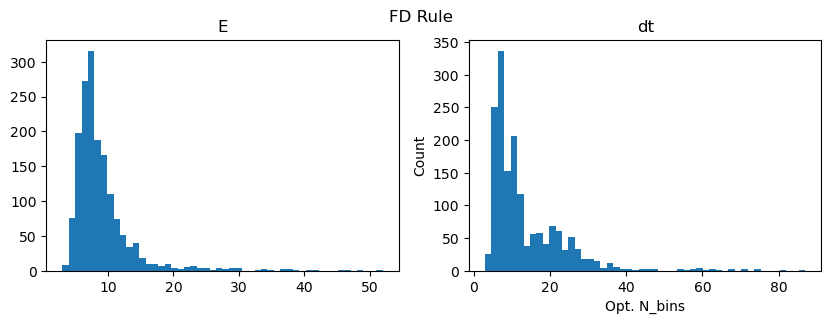

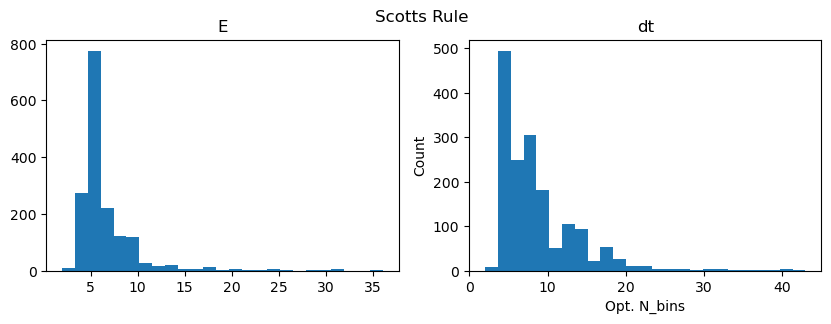

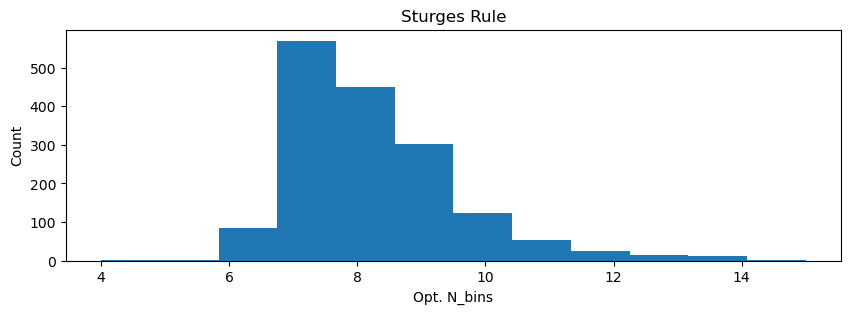

[9, 7, 10, 11, 10, 5, 6, 6, 8, 8, 8, 6, 7, 12, 8, 7, 11, 25, 7, 11, 11, 5, 10, 7, 6, 15, 8, 6, 12, 7, 7, 6, 4, 7, 6, 10, 9, 6, 4, 9, 8, 6, 8, 7, 8, 7, 5, 7, 6, 6, 5, 5, 5, 7, 8, 9, 8, 7, 10, 8, 5, 4, 7, 8, 8, 8, 6, 6, 5, 11, 6, 10, 11, 7, 7, 10, 5, 5, 7, 7, 4, 5, 7, 6, 7, 8, 14, 15, 7, 3, 7, 8, 6, 6, 4, 5, 10, 6, 4, 7, 14, 9, 6, 11, 10, 6, 5, 11, 12, 9, 7, 6, 7, 7, 13, 8, 7, 6, 4, 9, 7, 12, 4, 8, 17, 7, 7, 8, 7, 7, 8, 7, 7, 6, 5, 9, 4, 8, 6, 7, 13, 7, 7, 13, 8, 8, 8, 6, 12, 9, 8, 5, 7, 7, 11, 9, 5, 6, 4, 46, 5, 5, 12, 7, 12, 6, 4, 4, 10, 5, 7, 5, 4, 52, 10, 7, 9, 10, 9, 9, 7, 6, 4, 16, 6, 11, 7, 8, 6, 6, 12, 8, 8, 6, 10, 8, 4, 10, 8, 9, 10, 8, 6, 9, 7, 14, 6, 7, 13, 7, 4, 14, 6, 8, 9, 4, 5, 14, 7, 12, 15, 9, 6, 10, 5, 7, 9, 6, 19, 6, 10, 10, 9, 7, 5, 9, 7, 6, 10, 10, 8, 3, 6, 6, 41, 6, 5, 6, 6, 8, 5, 8, 5, 9, 7, 8, 9, 11, 7, 5, 16, 11, 47, 10, 6, 9, 14, 4, 8, 7, 23, 29, 25, 6, 6, 3, 5, 7, 6, 6, 7, 8, 7, 5, 8, 4, 12, 6, 7, 5, 6, 22, 4, 7, 7, 8, 5, 6, 9, 10, 6, 8, 9, 7, 6, 9, 6, 4, 9, 9,

In [46]:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Can also plot them on top of each other for comparison!!!

# IDEA: get only 2-3std away from mean and plot distributions again

# FD Rule
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 3))
fig.suptitle('FD Rule')
ax1.hist(nbin_E_list,bins=50)
ax1.set_title('E')
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(nbin_dt_list,bins=50)
ax2.set_title('dt')
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')

# Scotts Rule
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 3))
fig.suptitle('Scotts Rule')
ax1.hist(scotts_E_list,bins=25)
ax1.set_title("E")
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(scotts_dt_list,bins=25)
ax2.set_title("dt")
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')

# Sturges
fig2  = plt.subplots(1, 1,figsize=(10, 3))
plt.hist(sturges_list,bins=12)
plt.title('Sturges Rule')
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
plt.show()

# 
print(nbin_E_list)
print(nbin_dt_list)

Variation of Eventfile Lengths

In [ ]:
unique = df_inputs["obsreg_id"].unique()
evt_len_list =[]
# Loop over all events
for id in unique:
    df_test = df_inputs[df_inputs["obsreg_id"] == id]
    evt_len = len(df_test)
    evt_len_list.append(evt_len)

# Plot Distribution
plt.hist(evt_len_list,bins=20,range=[0, 1000])
plt.xlabel('Eventfile Lengths')
plt.ylabel('Count')
plt.show()



In [5]:
# Plot Distribution
plt.hist(evt_len_list,bins=100,range=[0, 500])
plt.xlabel('Eventfile Lengths')
plt.ylabel('Count')
plt.show()

NameError: name 'evt_len_list' is not defined

Variation of dt

In [ ]:
unique = df_inputs["obsreg_id"].unique()
maxdt_list = []

for id in unique:
    df_test = df_inputs[df_inputs["obsreg_id"] == id]
    df_test["delta_time"] = df_test['time'].diff()
    df_test = df_test[df_test["delta_time"].notna()]
    # Add a constant value to delta_time = 0
    #df_test["delta_time"] = df_test["delta_time"].apply(lambda dt: np.where(dt == 0, dt + 0.01, dt))
    print(max(df_test["delta_time"]),min(df_test["delta_time"]))

    # Number and Total Duration of Events
    N = len(df_test) #one row will be dropped so -1 ???
    T = max(df_test["time"])-min(df_test["time"])
    E = max(df_test["energy"])-min(df_test["energy"])
    # Add delta_t column
    df_test["dt"] = np.log10(100 * N * df_test["delta_time"]/T)
    # Add E column
    df_test["E"] = np.log10(df_test["energy"])
    # Max dt
    maxdt = max(df_test["dt"])
    maxdt_list.append(maxdt)

    fig = plt.figure(figsize = (12,6))
    ax = fig.gca()
    df_test.hist("delta_time",ax = ax,bins = 50)
    plt.show()


Max dt for dt axis

In [52]:
unique = df_inputs["obsreg_id"].unique()
maxdt_list = []
mindt_list = []

for id in unique:
    df_test = df_inputs[df_inputs["obsreg_id"] == id]
    df_test["delta_time"] = df_test['time'].diff()
    df_test = df_test[df_test["delta_time"].notna()]
    # Add a constant value to delta_time = 0
    df_test["delta_time"] = df_test["delta_time"].apply(lambda dt: np.where(dt == 0, dt + 0.01, dt))
    # Number and Total Duration of Events
    N = len(df_test) #one row will be dropped so -1 ???
    T = max(df_test["time"])-min(df_test["time"])
    E = max(df_test["energy"])-min(df_test["energy"])
    # Add delta_t column
    df_test["dt"] = np.log10(100 * N * df_test["delta_time"]/T)
    # Add E column
    df_test["E"] = np.log10(df_test["energy"])
    # Max dt
    maxdt = max(df_test["dt"])
    mindt = min(df_test["dt"])
    maxdt_list.append(maxdt)
    mindt_list.append(mindt)
print('Maximum: ', max(maxdt_list))
print('Minimum: ', min(mindt_list))

/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_2257/4121873518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["delta_time"] = df_test['time'].diff()
/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_2257/4121873518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["delta_time"] = df_test['time'].diff()
/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_2257/4121873518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Maximum:  4.214631444047545
Minimum:  -3.128574550253707


/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_2257/4121873518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["delta_time"] = df_test['time'].diff()
/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_2257/4121873518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["delta_time"] = df_test['time'].diff()
/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_2257/4121873518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da